In [1]:
import sys
import os
import numpy as np
import pandas as pd
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

    
from stochastic_simulation import *
from june_realistic import base_params
import matplotlib.pyplot as plt

In [2]:
# Make plots of 90% quantile of number of people in QI or QS vs. days of simulation
# Using june_realistic parameters 
# test_days = [300]
# time_horizon = 250

In [3]:
def sim_many_test_days(base_params, test_days, use_SIR_dynamics=False, time_horizon=250, only_bucket_test=True):
    dfs_cts = {}
    dfs_bucket = {}
    base_params_cts = base_params.copy()
    base_params_cts['days_between_tests'] = 1
    
    base_params_bucket = base_params.copy()
    base_params_bucket['test_population_fraction'] = 1
    
    for T in test_days:
        if not only_bucket_test:
            base_params_cts['test_population_fraction'] = 1/T
            if use_SIR_dynamics:
                sim_cts = SIRStochasticSimulation(base_params_cts)
            else:
                sim_cts = StochasticSimulation(base_params_cts)
            dfs_cts[T] = []
            for _ in range(100):
                dfs_cts[T].append(sim_cts.run_new_trajectory(time_horizon))
        
        base_params_bucket['days_between_tests'] = T
        if use_SIR_dynamics:
            sim_bucket = SIRStochasticSimulation(base_params_bucket)
        else:
            sim_bucket = StochasticSimulation(base_params_bucket)
        dfs_bucket[T] = []
        for _ in range(100):
            dfs_bucket[T].append(sim_bucket.run_new_trajectory(time_horizon))
        
        print("Done test frequency {}".format(T))
    
    return dfs_cts, dfs_bucket

In [4]:
cts, bucket = sim_many_test_days(base_params=base_params, 
                   test_days=[300], use_SIR_dynamics=False, time_horizon=250, only_bucket_test=True)


Done test frequency 300


In [7]:
QS_df = bucket[300][0]['QS']
QI_df = bucket[300][0]['QI']

Qtotal_df = QS_df.add(QI_df, fill_value=0)

for i in range(1,100):
    new_QS = bucket[300][i]['QS']
    new_QI = bucket[300][i]['QI']
    new_Qtotal = new_QS.add(new_QI, fill_value=0)
    
    QS_df = pd.concat([QS_df, new_QS], axis=1, sort=False)
    QI_df = pd.concat([QI_df, new_QI], axis=1, sort=False)
    Qtotal_df = pd.concat([Qtotal_df, new_Qtotal], axis=1, sort=False)

# pd.quantile not working here     
QS_quan = QS_df.T.quantile(.9)
QI_quan = QI_df.T.quantile(.9)
Qtotal_quan = Qtotal_df.T.quantile(.9)


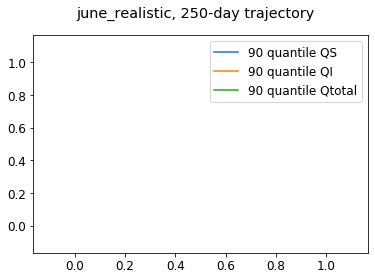

In [8]:
fig, ax = plt.subplots()
ax.plot(QS_quan, label='90 quantile QS')
ax.plot(QI_quan, label='90 quantile QI')
ax.plot(Qtotal_quan, label='90 quantile Qtotal')
fig.suptitle('june_realistic, 250-day trajectory')
ax.legend()